In [1]:
import os
import sys
import multiprocessing as mp
import pickle
from pathlib import Path
import wandb
import torch
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet
from collections import OrderedDict
from torch.utils.data import DataLoader
from lightning.pytorch import Trainer
from sklearn.metrics import roc_auc_score, roc_curve, auc

sys.path.append("../scripts/")
from asm_datamodules import *
from asm_models import *

In [2]:
%load_ext autoreload
%autoreload 2

# Test Dataloader

In [3]:
# datamodule parameters
root = "/n/holyscratch01/tambe_lab/kayan/karena/"
batch_size = 64
num_workers = 2
mines_only = False
split = False
split_n = None
split_path = "/n/home07/kayan/asm/data/splits/9_all_data_lowlr_save-split"
save_split = False

In [4]:
# get test dataloader from datamodule
datamodule = ASMDataModule(batch_size=batch_size, num_workers=num_workers, split=split, split_n=split_n, 
                           root=root, transforms=rcf, mines_only=mines_only, split_path=split_path)

datamodule.setup("test")
test_dataloader = datamodule.test_dataloader()

/n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# RCF Model

In [4]:
run = wandb.init()
artifact = run.use_artifact('asm_detect/ASM_seg/model-vtfgx35e:v0', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kayan (asm_detect). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [5]:
state_dict = torch.load(f"{artifact_dir}/model.ckpt")["state_dict"]

In [6]:
# model parameters
lr = 1e-4
loss = "ce"
class_weights = [0.2,0.8]

task = CustomSemanticSegmentationTask(
    model="rcf",
    weights=True,
    loss=loss,
    class_weights = torch.Tensor(class_weights) if class_weights is not None else None,
    in_channels=16,
    num_classes=2,
    lr=lr
)

task.load_state_dict(state_dict)

<All keys matched successfully>

## Run Inference

In [9]:
# Put model on evaluation mode and load to local device
task.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
task = task.to(device)

In [ ]:
pixelwise_predictions = {}

with torch.inference_mode():
    for idx,samples in enumerate(test_dataloader):
        unique_ids = samples['id']
        
        # Move input data to the device
        inputs = samples['image'].to(device)

        # Forward pass
        outputs = task(inputs)
        outputs = torch.softmax(outputs, dim=1)
        #outputs = outputs.argmax(dim=1).squeeze()
        
        for unique_id,output in zip(unique_ids, outputs):
            pixelwise_predictions[unique_id] = output[1].cpu().numpy()
        print(idx, end=" ")

## Image-wide predictions

In [10]:
def pixelwise_to_prob(pixelwise_preds):
    class_proba = {}
    for (unique_id,preds) in pixelwise_preds.items():
        # average probability
        class_proba[unique_id] = np.mean(preds)
        #class_proba[unique_id] = np.mean(preds*(preds>0.5))
        #class_proba[unique_id] = np.sum((preds>0.5))
    return class_proba

In [15]:
class_proba = pixelwise_to_prob(pixelwise_predictions)

In [ ]:
path="/n/home07/kayan/asm/data/filtered_labels.geojson"
label_df = gpd.read_file(path)

true_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in class_proba.keys()]

In [17]:
class_proba = list(class_proba.values())

Text(0, 0.5, 'True Positive')

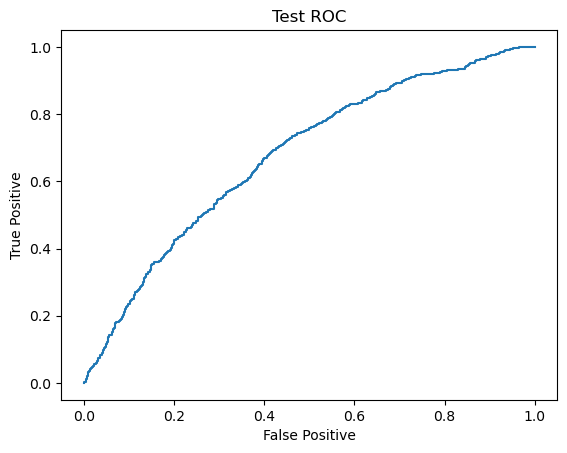

In [18]:
fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba)
ax.plot(fpr, tpr)
ax.set_title("Test ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

In [19]:
roc_auc_score(true_labels, class_proba)

0.6755631707454701

# UNet Model

In [5]:
artifact_dir = "/n/home07/kayan/asm/notebooks/artifacts/model-h2a1y1vd:v19"
state_dict = torch.load(f"{artifact_dir}/model.ckpt")["state_dict"]

In [6]:
# model parameters
lr = 1e-5
loss = "ce"
class_weights = [0.2,0.8]
freeze_backbone = False

task_unet = CustomSemanticSegmentationTask(
    model="unet",
    backbone="resnet18",
    weights=True,
    loss=loss,
    class_weights = torch.Tensor(class_weights),
    in_channels=4,
    num_classes=2,
    lr=lr,
    patience=5,
    freeze_backbone=freeze_backbone,
    freeze_decoder=False
)

task_unet.load_state_dict(state_dict)

<All keys matched successfully>

## Run inference

In [7]:
# Put model on evaluation mode and load to local device
task_unet.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
task_unet = task_unet.to(device)

In [8]:
pixelwise_predictions_unet = {}

with torch.inference_mode():
    for idx,samples in enumerate(test_dataloader):
        unique_ids = samples['id']
        
        # Move input data to the device
        inputs = samples['norm_image'].to(device)

        # Forward pass
        outputs = task_unet(inputs)
        outputs = torch.softmax(outputs, dim=1)
        #outputs = outputs.argmax(dim=1).squeeze()
        
        for unique_id,output in zip(unique_ids, outputs):
            pixelwise_predictions_unet[unique_id] = output[1].cpu().numpy()
        print(f"Batch {idx}")

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43


## Convert pixelwise predictions to image-wide label

In [12]:
class_proba_unet = pixelwise_to_prob(pixelwise_predictions_unet)

In [13]:
path="/n/home07/kayan/asm/data/filtered_labels.geojson"
label_df = gpd.read_file(path)

true_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in class_proba_unet.keys()]

In [14]:
class_proba_unet = list(class_proba_unet.values())

Text(0, 0.5, 'True Positive')

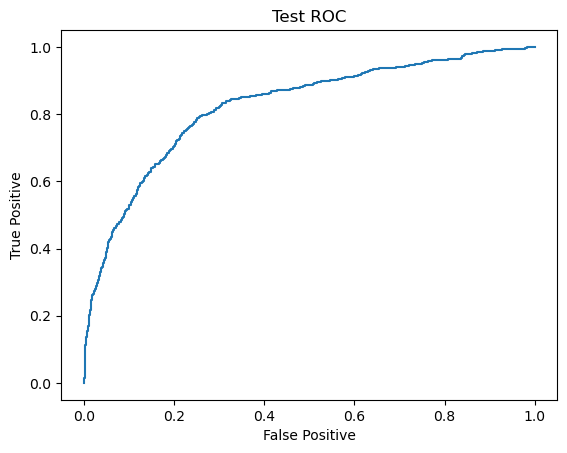

In [15]:
fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba_unet)
ax.plot(fpr, tpr)
ax.set_title("Test ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

In [16]:
roc_auc_score(true_labels, class_proba_unet)

0.823870265225169

# Visualizing predictions

In [37]:
true_labels[30:40]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

In [38]:
list(pixelwise_predictions_unet.keys())[30:40]

['lat_-2--165__lon_26--575',
 'lat_-4--935__lon_30--265',
 'lat_-0--565__lon_26--505',
 'lat_7--825__lon_-11--275',
 'lat_-21--265__lon_30--135',
 'lat_-1--115__lon_28--295',
 'lat_7--425__lon_19--885',
 'lat_3--495__lon_15--955',
 'lat_8--095__lon_22--425',
 'lat_-3--615__lon_27--715']

In [21]:
def load_img(img_id):
    img_path = root+"images/"+img_id+".tif"
    img = rasterio.open(img_path)
    img = img.read([3,2,1]) #RGB channels
    
    # normalize per channel
    img_norm = (img.T - np.min(img,axis=(1,2))) / (np.max(img,axis=(1,2)) - np.min(img,axis=(1,2))) # we take the transpose to allow for broadcasting
    img_norm = img_norm.T # undo transpose
    return img_norm

def load_raster(raster_id):
    raster_path = root+"rasters/"+raster_id+".tif"
    raster = rasterio.open(raster_path)
    raster = raster.read([1])
    return raster

In [93]:
def four_panel_plot(image_id):
    # input image
    plt.subplot(141)
    img = load_img(image_id)
    plt.imshow(np.moveaxis(img,0,-1))
    plt.axis("off")
    plt.title("Input")
    
    # true labels
    plt.subplot(142)
    raster = load_raster(image_id)
    plt.imshow(np.moveaxis(raster,0,-1),cmap="gray")
    plt.axis("off")
    plt.title("Raster")
    
    # rcf model prediction
    plt.subplot(143)
    plt.imshow(pixelwise_predictions[image_id],cmap="gray",vmin=0,vmax=1)
    plt.axis("off")
    plt.title("RCF Pred.")
    
    # unet model prediction
    plt.subplot(144)
    plt.imshow(pixelwise_predictions_unet[image_id],cmap="gray",vmin=0,vmax=1)
    plt.axis("off")
    plt.title("UNet Pred.")

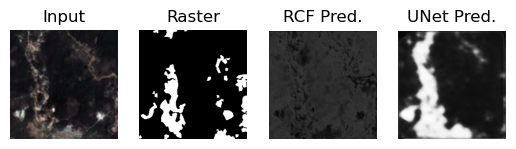

In [94]:
four_panel_plot('lat_8--575__lon_-11--705')

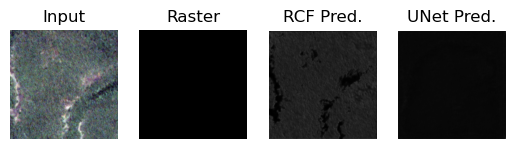

In [95]:
four_panel_plot('lat_6--695__lon_15--875')

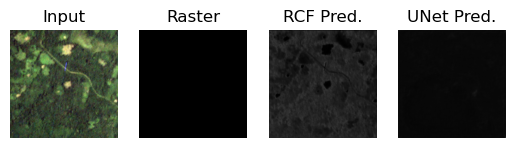

In [96]:
four_panel_plot('lat_-1--395__lon_26--595')

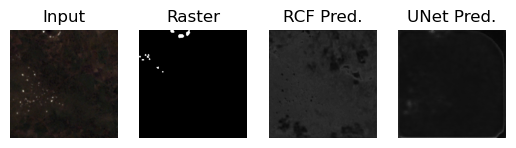

In [100]:
four_panel_plot('lat_-5--075__lon_30--155')

In [52]:
list(pixelwise_predictions_unet.keys())[40:50]

['lat_-5--045__lon_28--885',
 'lat_8--505__lon_-11--295',
 'lat_1--065__lon_29--185',
 'lat_-4--745__lon_28--685',
 'lat_-0--155__lon_29--245',
 'lat_-1--715__lon_26--395',
 'lat_0--925__lon_19--995',
 'lat_-3--665__lon_23--615',
 'lat_-8--275__lon_25--365',
 'lat_8--265__lon_-11--155']

Text(0.5, 1.0, 'Prediction')

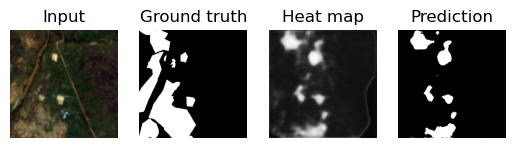

In [56]:
image_id = 'lat_-4--745__lon_28--685'
# input image
plt.subplot(141)
img = load_img(image_id)
plt.imshow(np.moveaxis(img,0,-1))
plt.axis("off")
plt.title("Input")

# true labels
plt.subplot(142)
raster = load_raster(image_id)
plt.imshow(np.moveaxis(raster,0,-1),cmap="gray")
plt.axis("off")
plt.title("Ground truth")

# unet model prediction
plt.subplot(143)
plt.imshow(pixelwise_predictions_unet[image_id],cmap="gray",vmin=0,vmax=1)
plt.axis("off")
plt.title("Heat map")

# unet model prediction
plt.subplot(144)
plt.imshow(pixelwise_predictions_unet[image_id]>0.5,cmap="gray")
plt.axis("off")
plt.title("Prediction")